# Train-test-val split
## Requirements:
- Split 80 - 20 (Due to small dataset size, I think we should omit a validation set)
- No two photos taken at the same encounter (location+bear) should be end up in different sets. In other words, the 'atoms' are the encounters, they can not be split any more.

## Types of (re-)identification
I identify three different forms of (re-)identification:
1. Confirmation: two images are of the same individual
2. Closed-set identification: assign probe image to correct individual (cluster of images)
3. Open-set identification: assign probe image to correct individual, or create new one if no match.

I think type 3 is closest to the real-world scenario, so we should focus on this type. We can evaluate by gallery querying.
To do so and to avoid data leakage we should split by individual.

## Evaluation
Evaluation is done by using gallery querying. We split the test set into a gallery and a set of query images (k-fold).
Then we calculate the mAP@K metric for different k, meaning: we check if the correct individual is in the top-k individuals as predicted by the model.
How we actually query is to be decided. You could for example consider each image separately or create a centroid (mean of embeddings of 1 individual).
During evaluation, photos of the same individual at the same moment should be omitted as it messes with the metric scores.

First, we will create a single dataframe containing every image in the set and the corresponding metadata, that is, origin dir (brookFalls/britishColumbia) individual id and 'encounter' (subdir).

In [79]:
import os
import pandas as pd
from pathlib import Path
import random
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset

In [38]:
"""The root dir contains the chip directories brooksFalls and britishColumbia
"""
root_dir = Path("../../../data/07_model_output/bearfacesegmentation/chips/yolov8/resized/square_dim_150/")

True

In [19]:
# Utility function
def list_subdirs(dir):
  return [item for item in os.listdir(dir) if os.path.isdir(os.path.join(dir, item))]

In [20]:
# origins = ["brooksFalls", "britishColumbia"]
origins = ["brooksFalls"]

In [46]:
# Locate every chip in the dataset
samples = []
for origin in origins:
  for encounter in list_subdirs(os.path.join(root_dir, origin)):
    for bear_id in list_subdirs(os.path.join(root_dir, origin, encounter)):
      for image in os.listdir(os.path.join(root_dir, origin, encounter, bear_id)):
        samples.append({
            "origin": origin,
            "encounter": encounter,
            "bear_id": bear_id,
            "image": image,
            "path": root_dir / origin / encounter / bear_id / image,
            })

In [64]:
samples[:1]

[{'origin': 'brooksFalls',
  'encounter': 'je_201708',
  'bear_id': 'bf_480',
  'image': '480-otis_14592316682_o.jpg',
  'path': PosixPath('../../../data/07_model_output/bearfacesegmentation/chips/yolov8/resized/square_dim_150/brooksFalls/je_201708/bf_480/480-otis_14592316682_o.jpg')}]

In [48]:
df = pd.DataFrame(samples)

# Discard rows where bear_id occurs only once
df_filtered = df.groupby('bear_id').filter(lambda x: len(x) > 1)
print(f"Discarded {len(df) - len(df_filtered)} rows")
diff_index = df.index.difference(df_filtered.index)

discarded = df.loc[diff_index]

Discarded 5 rows


In [49]:
df.bear_id.nunique()

73

In [50]:
# group by bear_id
bears = [x for _, x in df_filtered.groupby("bear_id")]
single_bears = [x for _, x in discarded.groupby("bear_id")]

**Now** that we have dataframes for each origin, encounter and bear_id, we can split them into train and test sets.

In [65]:
random.seed(0)
split_proportion = 0.7


shuffled_bears = random.sample(bears, len(bears))
train_split = shuffled_bears[:int(split_proportion * len(shuffled_bears))]
test_split = shuffled_bears[int(split_proportion * len(shuffled_bears)):]
test_split.extend(single_bears) # We can use the individuals with one image during testing

# Sanity check
assert len(df.bear_id.unique()) == len(train_split) + len(test_split)

Now that we have split the individual bears, we should account for the similar photos of bears, being photos with the same 'encounter'.
We can do this when we sample, as we treat this case differently when training than when testing.  
When training we are okay with sampling all images from the same encounter, as it can be seen as oversampling + augmentation. However when training with triplet loss, we do not want the anchor and positive sample to be of the same encounter.  
When testing, we only want to use one image of every encounter, as using multiple will influence the testing metrics, as in general you do not oversample and use data augmentation when testing.

In [52]:
class BearTripletDataset(Dataset):
    def __init__(self, dataframe, train=True, transform=None):
        self.dataframe = dataframe
        self.train = train
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if self.train:
            # Sample a triplet
            anchor_sample = self.dataframe.iloc[idx]
            bear_id = anchor_sample['bear_id']
            encounter_id = anchor_sample['encounter']
            path = anchor_sample['path']

            # Get all samples for the same bear_id
            bear_samples = self.dataframe[self.dataframe.bear_id == bear_id]

            # Filter out the anchor's encounter if there is more than 1
            if len(bear_samples.encounter.unique()) > 1:
                possible_positives = bear_samples[bear_samples.encounter != encounter_id]
                # possible_positives = [sample for sample in bear_samples if sample['encounter'] != encounter_id]
            else:
                # If not, we can select from the same encounter
                possible_positives = bear_samples[bear_samples.path != path]

            positive_sample = possible_positives.sample()

            # Select a negative sample from a different bear
            other_bears = self.dataframe[self.dataframe.bear_id != bear_id]
            negative_sample = other_bears.sample()

            anchor_path = path
            positive_path = positive_sample.path.item()
            negative_path = negative_sample.path.item()

            anchor_image = Image.open(anchor_path)
            positive_image = Image.open(positive_path)
            negative_image = Image.open(negative_path)

            if self.transform:
                anchor_image = self.transform(anchor_image)
                positive_image = self.transform(positive_image)
                negative_image = self.transform(negative_image)

            return {'anchor': anchor_image, 'positive': positive_image, 'negative': negative_image}

        else:
            # Testing logic to fetch a single image per encounter
            sample = self.dataframe.iloc[idx]
            image = Image.open(sample.path)
            if self.transform:
                image = self.transform(image)
            return sample.bear_id, image

In [53]:
# Initialize your dataset class for both training and testing
train_set =  pd.concat(train_split)
test_set = pd.concat(test_split)

# Sanity check
# assert len(df) == len(train_set) + len(test_set)
train_dataset = BearTripletDataset(train_set, train=True)
test_dataset = BearTripletDataset(test_set, train=False)

In [115]:
def display_triplet(sample):
    fig, ax = plt.subplot_mosaic([["anchor", "positive", "negative"]], figsize = (10,4))
    ax["anchor"].imshow(sample["anchor"])
    ax["anchor"].axis("off")
    ax["anchor"].set_title("anchor")
    ax["positive"].imshow(sample["positive"])
    ax["positive"].axis("off")
    ax["positive"].set_title("positive")
    ax["negative"].imshow(sample["negative"])
    ax["negative"].axis("off")
    ax["negative"].set_title("negative")
    plt.show()

def display_test_sample(bear_id, path):
    fig, ax = plt.subplot_mosaic([["sample"]], figsize = (3,3))
    ax["sample"].imshow(path)
    ax["sample"].axis("off")
    ax["sample"].set_title(f"{bear_id}")
    plt.show()

Training Samples:


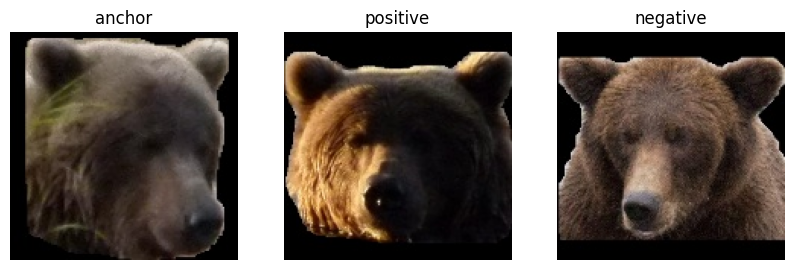

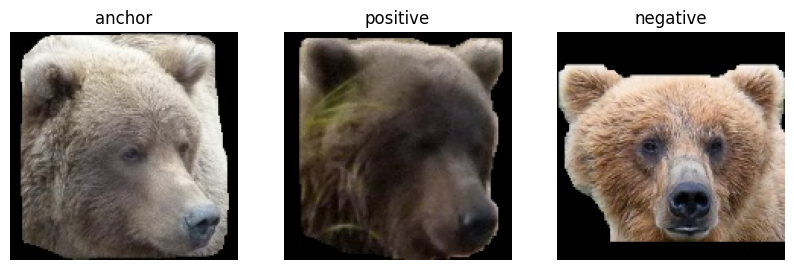

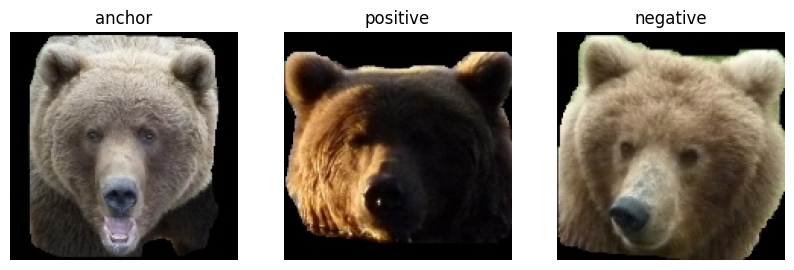

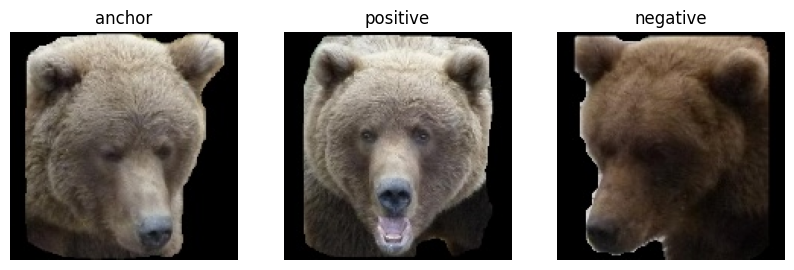

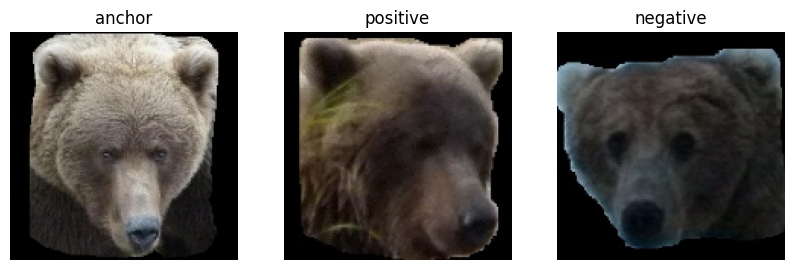


Testing Samples:


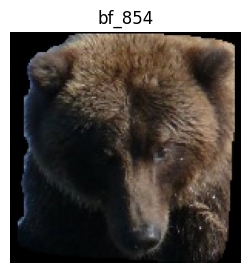

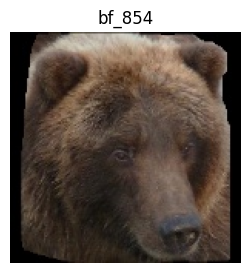

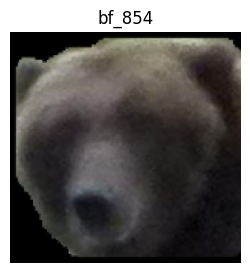

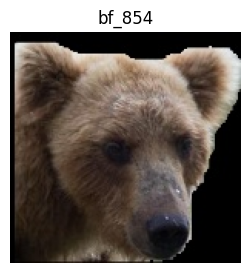

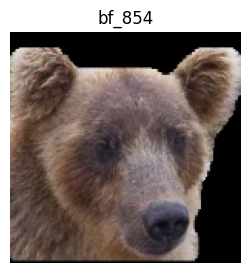

In [116]:
# Testing the training dataset
print("Training Samples:")
for i in range(min(5, len(train_dataset))):
    sample = train_dataset[i]
    display_triplet(sample)

# Testing the testing dataset
print("\nTesting Samples:")
for i in range(min(5, len(test_dataset))):
    bear_id, image = test_dataset[i]
    display_test_sample(bear_id, image)

In [55]:
unique_encounters = df.groupby('bear_id')['encounter'].nunique()

<Axes: >

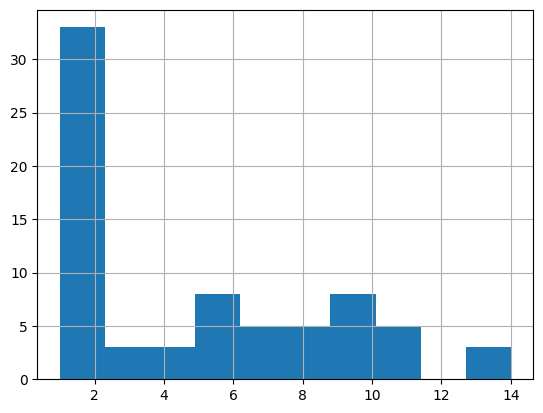

In [56]:
unique_encounters.hist()

In [57]:
test_set.bear_id.value_counts()

bear_id
bf_410    191
bf_151    178
bf_068     92
bf_747     86
bf_505     79
bf_856     67
bf_094     62
bf_435     58
bf_132     58
bf_634     51
bf_402     50
bf_854     49
bf_602     44
bf_451     31
bf_611     24
bf_718     14
bf_401      6
bf_600      4
bf_469      3
bf_218      3
bf_489      2
bf_039      1
bf_263      1
bf_415      1
bf_511      1
bf_818      1
Name: count, dtype: int64

In [58]:
save_dir = Path("../../../data/04_feature/bearidentification/bearid/data_split/")

In [59]:
os.makedirs(save_dir, exist_ok=True)

In [60]:
train_set.to_csv(save_dir / "train_set_base.csv", sep=';')
test_set.to_csv(save_dir / "test_set_base.csv", sep=';')

In [61]:
bear_id_counts = test_set['bear_id'].value_counts()
bear_id_more_than_once = bear_id_counts[bear_id_counts > 1]

In [62]:
bear_id_more_than_once

bear_id
bf_410    191
bf_151    178
bf_068     92
bf_747     86
bf_505     79
bf_856     67
bf_094     62
bf_435     58
bf_132     58
bf_634     51
bf_402     50
bf_854     49
bf_602     44
bf_451     31
bf_611     24
bf_718     14
bf_401      6
bf_600      4
bf_469      3
bf_218      3
bf_489      2
Name: count, dtype: int64

In [63]:
test_set.to_csv(save_dir / "testset_split_c.csv", sep=';', index=False) #sep = ";" cause there are file names with ","
train_set.to_csv(save_dir / "trainset_split_c.csv", sep=';', index=False) #sep = ";" cause there are file names with ","